In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import time
import matplotlib.pyplot as plt
import sys
import time
import random

env = gym.make('A1Soccer-v2', render_mode = 'human')

In [2]:
def move_jointer(joint_torque_dict):
    x = np.zeros(12)

    for target_joint_index_key in joint_torque_dict.keys():
        x[target_joint_index_key] = joint_torque_dict[target_joint_index_key]
        
    return x

def statuser(sent_data):
    print("Action: ", sent_data)
    print("Ctrl data: ", env.data.ctrl)
    print("Actual observation: ", env.current_sim_state.sensed_joints_qpos)

    print("\n \n \n")

def mover():
    joint_index = 0
    increment  = 0.25
    while True:
        if joint_index <= 10.75:
            joint_index += increment
        else:
            joint_index = 0

        print(int(joint_index))
        #sample action sent
        # x = env.action_space.sample()
        x  = move_jointer(int(joint_index), 10)

        env.step(x)

        statuser(x)

In [3]:
def mover_plot_joint(joint_index, joint_acting_torque):
    qpos_len = len(env.data.qpos)
    qvel_len = len(env.data.qvel)

    qpos_data_store = [[] for _ in range(qpos_len)]
    qvel_data_store = [[] for _ in range(qvel_len)]

    # Simulate and collect data for 60 seconds
    start_time = time.time()
    max_runtime = 30

    env.reset()
    time.sleep(1)

    y = move_jointer(joint_index, joint_acting_torque)
    while time.time() - start_time < max_runtime:
        y = -y

        env.step(y)  

        for i in range(qpos_len):
            qpos_data_store[i].append(env.data.qpos[i])
        for i in range(qvel_len):
            qvel_data_store[i].append(env.data.qvel[i])

        time.sleep(0.1)
        env.render()

    # Create subplots
    rows, cols = 5, 6  # Adjust these to arrange your subplots
    fig0, axes0 = plt.subplots(rows, cols, figsize=(12, 8))  # Adjust figsize if needed
    fig1, axes1 = plt.subplots(rows, cols, figsize=(12, 8))  # Adjust figsize if needed

    qpos_time_axis = np.arange(len(qpos_data_store[0]))
    qvel_time_axis = np.arange(len(qvel_data_store[0])) 

    for i0, ax0 in enumerate(axes0.flat):
        if i0 < qpos_len:
            ax0.plot(qpos_time_axis, qpos_data_store[i0])
            ax0.set_xlabel("Time Steps")
            ax0.set_ylabel(f"qpos[{i0}]")  
            ax0.set_title(f"qpos[{i0}]")
        else: 
            ax0.axis('off')  # Hide unused subplots

    for i1, ax1 in enumerate(axes1.flat):
        if i1 < qvel_len:
            ax1.plot(qvel_time_axis, qvel_data_store[i1])
            ax1.set_xlabel("Time Steps")
            ax1.set_ylabel(f"qvel[{i1}]")  
            ax1.set_title(f"qvel[{i1}]")
        else: 
            ax1.axis('off')  # Hide unused subplots 

    fig0.tight_layout()  # Adjust spacing between subplots 
    fig1.tight_layout()  # Adjust spacing between subplots 

    plt.show()

In [4]:
def print_sensed_sim_state(env):
    x = env.current_sim_state

    print("sensed_joints_qpos_dict: ", x.sensed_joints_qpos_dict, "\n sensed_joints_qvel_dict: ", x.sensed_joints_qvel_dict)
    print("\n \n \n")

In [5]:
# env.reset()

# time.sleep(3)
# while True:
#     x = env.action_space.sample()
#     env.step(x)
#     print_sensed_sim_state(env)

#     time.sleep(0.1)
#     env.render()

In [6]:
# env.reset()

# time.sleep(1)

# start_time = time.time()
# max_runtime = 3

# while time.time() - start_time < max_runtime:
#     x = env.action_space.sample()
#     env.step(x)


#     print("sensed_joints_qpos_dict: ", env.current_sim_state.sensed_joints_qpos_dict)
#     print("joints_qpos_dict: ", env.current_sim_state.joints_qpos_dict)


#     print()
#     print("sensed_joints_qvel_dict: ", env.current_sim_state.sensed_joints_qvel_dict)
#     print("joints_qvel_dict: ", env.current_sim_state.joints_qvel_dict)
#     print("\n \n \n")
    

#     time.sleep(0.1)
#     env.render()

In [7]:
def pd_controller(qpos_current, qvel_current, qpos_target, Kp, Kd):
    """
    Simple PD controller for a motor.

    Parameters:
    - qpos_current: Current position of the joint.
    - qvel_current: Current velocity of the joint.
    - qpos_target: Target position for the joint.
    - Kp: Proportional gain.
    - Kd: Derivative gain.

    Returns:
    - control_input: The computed control input (e.g., torque) to apply to the joint.
    """
    # Compute position error
    error = qpos_target - qpos_current
    
    # Compute control input
    control_input = Kp * error - Kd * qvel_current
    
    return control_input

def simulate_and_plot_joint_control(joint_indices, target_qpos, Kp, Kd, num_steps, sensed_joints_qpos, sensed_joints_qvel):
    """
    Simulates PD control on a specified joint and plots its qpos and qvel over time.
    
    Parameters:
    - joint_index: Index of the joint to control.
    - target_qpos: Target position for the joint.
    - Kp: Proportional gain for PD controller.
    - Kd: Derivative gain for PD controller.
    - num_steps: Number of simulation steps to run.
    - sensed_joints_qpos: Initial sensed positions of all joints.
    - sensed_joints_qvel: Initial sensed velocities of all joints.
    """

    joint_index = joint_indices[0]
    
    # Initialize lists to store qpos and qvel for plotting
    qpos_history = []
    qvel_history = []

    env.reset()
    time.sleep(1)
    
    # Simulation loop
    for step in range(num_steps):
        # Current state for the specified joint
        current_qpos = sensed_joints_qpos[joint_index]
        current_qvel = sensed_joints_qvel[joint_index]
        
        # Apply PD controller to get control input
        control_input = pd_controller(current_qpos, current_qvel, target_qpos, Kp, Kd)

        joint_control_dict = {joint_index: control_input}
        x = move_jointer(joint_control_dict)
        env.step(x)
        
        # # Here, you would typically apply the control_input to the joint
        # # For this example, let's simulate the effect of the control input (this is a placeholder for your actual control application logic)
        # sensed_joints_qpos[joint_index] += current_qvel * 0.01  # Simulate position update (assuming dt=0.01 for simplicity)
        # sensed_joints_qvel[joint_index] += control_input * 0.01  # Simulate velocity update

        time.sleep(0.1)
        env.render()
        
        # Store current state for plotting
        qpos_history.append(sensed_joints_qpos[joint_index])
        qvel_history.append(sensed_joints_qvel[joint_index])
    
   # Plotting
    time_steps = np.arange(num_steps)
    target_qpos_array = [target_qpos] * num_steps  # Create an array with the target position repeated for each time step

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(time_steps, qpos_history, label='Actual qpos')
    plt.plot(time_steps, target_qpos_array, 'r--', label='Target qpos')  # Plot the target qpos as a dashed red line
    plt.xlabel('Time Step')
    plt.ylabel('Position')
    plt.title('Joint Position Over Time')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(time_steps, qvel_history, label='qvel')
    plt.xlabel('Time Step')
    plt.ylabel('Velocity')
    plt.title('Joint Velocity Over Time')
    plt.legend()

    plt.tight_layout()
    plt.show()

def simulate_and_plot_multi_joint_control(joint_indices, target_qpos, Kp, Kd, num_steps, sensed_joints_qpos, sensed_joints_qvel):
    """
    Simulates PD control on a specified joint and plots its qpos and qvel over time.
    
    Parameters:
    - joint_index: Index of the joint to control.
    - target_qpos: Target position for the joint.
    - Kp: Proportional gain for PD controller.
    - Kd: Derivative gain for PD controller.
    - num_steps: Number of simulation steps to run.
    - sensed_joints_qpos: Initial sensed positions of all joints.
    - sensed_joints_qvel: Initial sensed velocities of all joints.
    """
    
    # Initialize lists to store qpos and qvel for plotting
    qpos_joints_history = []
    qvel_joints_history = []

    env.reset()
    # x = env.action_space.sample()
    # env.step(x)

    time.sleep(3)
    
    # Simulation loop
    for step in range(num_steps):
        # Current state for the specified joints
        joints_control_input = {}
        for joint_index in joint_indices:
            current_joint_qpos = sensed_joints_qpos[joint_index]
            current_joint_qvel = sensed_joints_qvel[joint_index]
            # Apply PD controller to get control input
            joint_control_input = pd_controller(current_joint_qpos, current_joint_qvel, target_qpos, Kp, Kd)
            
            # # if joint_index in [0, 6]:
            # if joint_index in [3, 9]:
            #     joint_control_input = -joint_control_input
            #     # joint_control_input += 0.802851

            
            joints_control_input[joint_index] = joint_control_input


        x = move_jointer(joints_control_input)
        env.step(x)
        
        # # Here, you would typically apply the control_input to the joint
        # # For this example, let's simulate the effect of the control input (this is a placeholder for your actual control application logic)
        # sensed_joints_qpos[joint_index] += current_qvel * 0.01  # Simulate position update (assuming dt=0.01 for simplicity)
        # sensed_joints_qvel[joint_index] += control_input * 0.01  # Simulate velocity update

        time.sleep(0.1)
        env.render()
        
        # Store new state for plotting
        current_joints_qpos = []
        current_joints_qvel = []
        for joint_index in joint_indices:
            current_joints_qpos.append(sensed_joints_qpos[joint_index])
            current_joints_qvel.append(sensed_joints_qvel[joint_index])

        qpos_joints_history.append(current_joints_qpos)
        qvel_joints_history.append(current_joints_qvel)



    time_steps = np.arange(num_steps)
    target_qpos_array = [target_qpos] * num_steps

    plt.figure(figsize=(12, 6))

    # Plot all actual qpos at the same time
    plt.subplot(1, 2, 1)
    for item_index, joint_index in enumerate(joint_indices):
        plt.plot(time_steps, [qpos[item_index] for qpos in qpos_joints_history], label=f'Joint {joint_index} qpos')

    plt.plot(time_steps, target_qpos_array, 'r--', label='Target qpos')  # Plot the target qpos as a dashed red line
    plt.xlabel('Time Step')
    plt.ylabel('Position')
    plt.title('Joints Position Over Time')
    plt.legend()

    # Plot all qvel at the same time
    plt.subplot(1, 2, 2)
    for item_index, joint_index in enumerate(joint_indices):
        plt.plot(time_steps, [qvel[item_index] for qvel in qvel_joints_history], label=f'Joint {joint_index} qvel')
        
    plt.xlabel('Time Step')
    plt.ylabel('Velocity')
    plt.title('Joints Velocity Over Time')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [8]:
def joint_name_to_indices(joint_group_name):
    if joint_group_name == "hip_right":
        return [0, 6]
    if joint_group_name == "hip_left":
        return [3, 9]
    if joint_group_name == "thigh":
        return [1, 4, 7, 10]
    if joint_group_name == "calf":
        return[2, 5, 8, 11]

In [9]:
def random_target_joint_qpos(joint_group_name):
    if joint_group_name == "hip_right":
        joint_range = env.joint_ranges_dict["FR_hip_joint"]
        min, max = joint_range
        return random.uniform(min, max)
    
    if joint_group_name == "hip_left":
        joint_range = env.joint_ranges_dict["FR_hip_joint"]
        min, max = joint_range
        return random.uniform(-min, -max)

    if joint_group_name == "thigh":
        joint_range = env.joint_ranges_dict["FR_thigh_joint"]
    if joint_group_name == "calf":
        joint_range = env.joint_ranges_dict["FR_calf_joint"]
    
    min, max = joint_range
    return random.uniform(min, max)

target_qpos: -1.8282551196574846


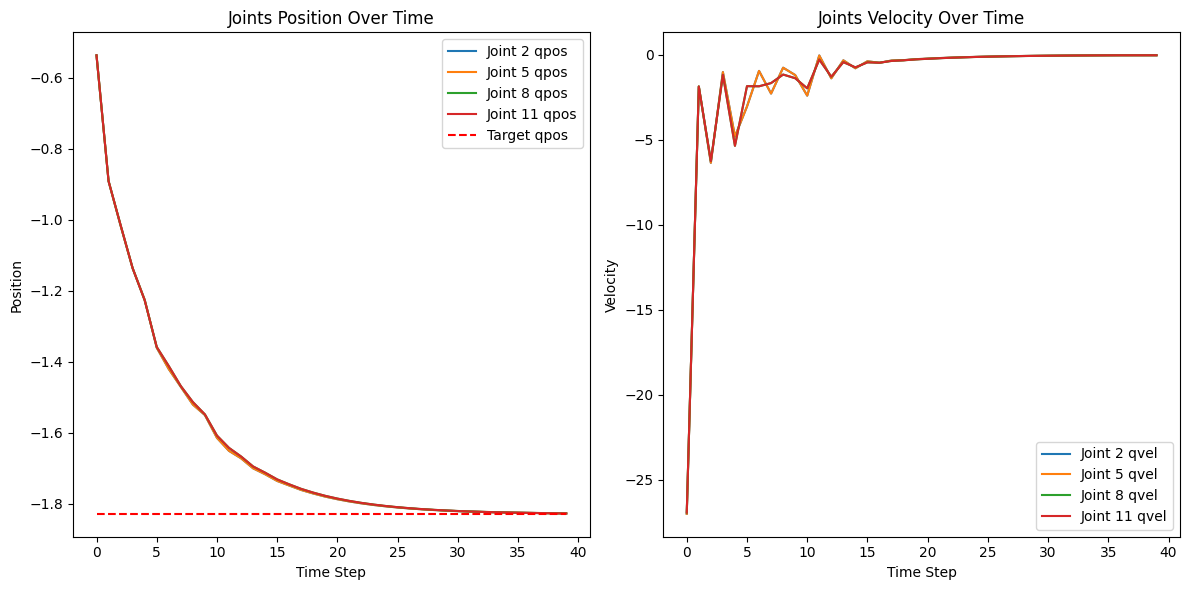

In [11]:
target_joint_group = "calf"

joint_indices = joint_name_to_indices(target_joint_group)
joint_target_qpos = random_target_joint_qpos(target_joint_group)

# joint_midpoint_qpos = sum(env.joint_ranges_dict[env.current_sim_state.joints[joint_indices[0]] + "_joint"])/0.5
print("target_qpos:", joint_target_qpos)

Kp = 4.75
Kd = 1

num_steps = 40

sensed_joints_qpos = env.current_sim_state.sensed_joints_qpos
sensed_joints_qvel = env.current_sim_state.sensed_joints_qvel

simulate_and_plot_multi_joint_control(joint_indices, joint_target_qpos, Kp, Kd, num_steps, sensed_joints_qpos, sensed_joints_qvel)

left: 3,9, right: 0,6

left goes naturally to positive; right goes naturally to negative\

7.5, 1.2

24;1.45 calf for 0.7